# Project Overview
Ini merupakan lanjutan dari analisis sebelumnya dengan RFM, Sekarang lebih difokuskan pada analisis sentimen dari review pelanggan terhadap produk yang dijual di e-commerce.

Tujuannya: Untuk memprediksi sentimen dari review pelanggan terhadap produk yang dijual di e-commerce.

Dataset: order_reviews_dataset.csv

# Import Libraries

In [1]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zup_92\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Zup_92\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Load Dataset

In [2]:
missing = ['n/a', 'na', '--', '', ' ', 'nan', 'Nan', 'NaN', 'NAN']

order_reviews_dataset = pd.read_csv('order_reviews_dataset.csv')
order_reviews_dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [3]:
#ambil kolom yang dipakai untuk sentimen
order_reviews_dataset = order_reviews_dataset[['review_comment_message', 'review_score']]
order_reviews_dataset.head()

,review_comment_message,review_score
0,NaN,4
1,NaN,5
2,NaN,5
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5


In [4]:
order_reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_message  40977 non-null  object
 1   review_score            99224 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
#penentuan label sentimen berdasarkan review_score (1-2: negatif, 3: netral, 4-5: positif)
order_reviews_dataset['sentimen'] = np.where(order_reviews_dataset['review_score'] > 3, 'positif', np.where(order_reviews_dataset['review_score'] < 3, 'negatif', 'netral'))
order_reviews_dataset.head()

,review_comment_message,review_score,sentimen
0,NaN,4,positif
1,NaN,5,positif
2,NaN,5,positif
3,Recebi bem antes do prazo estipulado.,5,positif
4,Parabéns lojas lannister adorei comprar pela I...,5,positif


In [6]:
order_reviews_dataset.shape

(99224, 3)

In [7]:
order_reviews_dataset.isnull().sum()

review_comment_message    58247
review_score                  0
sentimen                      0
dtype: int64

In [8]:
order_reviews_dataset = order_reviews_dataset.dropna()

order_reviews_dataset.isnull().sum()

review_comment_message    0
review_score              0
sentimen                  0
dtype: int64

In [9]:
order_reviews_dataset.shape

(40977, 3)

In [10]:
data_sentimen = order_reviews_dataset.copy()

In [11]:
data_sentimen.head()

,review_comment_message,review_score,sentimen
3,Recebi bem antes do prazo estipulado.,5,positif
4,Parabéns lojas lannister adorei comprar pela I...,5,positif
9,aparelho eficiente. no site a marca do aparelh...,4,positif
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,positif
15,"Vendedor confiável, produto ok e entrega antes...",5,positif


# Exploratory Data Analysis

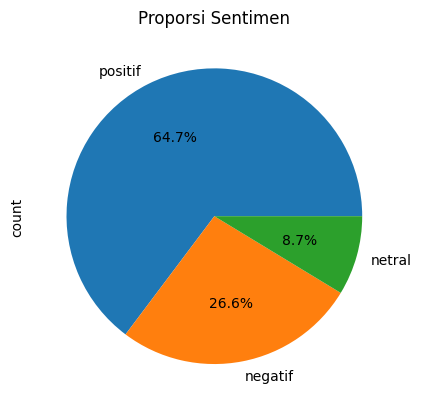

In [12]:
#Ce proporsi tiap label dan plot dengan pie
data_sentimen['sentimen'].value_counts(normalize=True)

fig, ax = plt.subplots()
data_sentimen['sentimen'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title('Proporsi Sentimen')
plt.show()

In [13]:
# Word Cloud Data Asli (Sebelum Diolah)
word_sebelum_diolah = pd.Series(" ".join(data_sentimen["review_comment_message"]).split())
len(word_sebelum_diolah)

478579

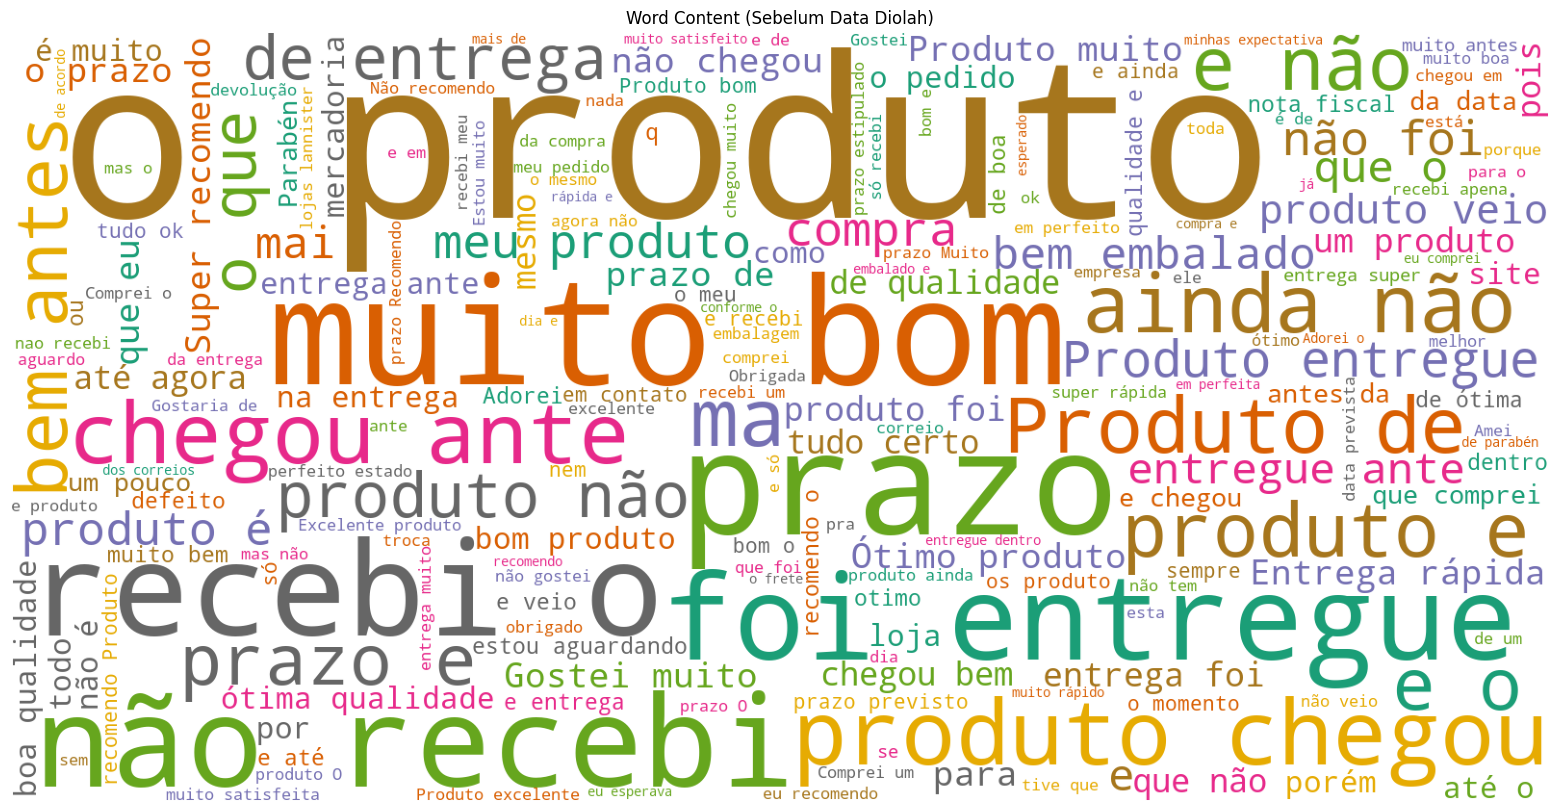

In [14]:
# WORDCLOUD CONTENT SECARA KESELURUHAN (DATA SEBELUM DIOLAH)
from wordcloud import WordCloud
dat_sebelum_diolah = " ".join(word_sebelum_diolah)

# Bigram (per dua kata) -> "collocations = True"
wordcloud_sblm = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2").generate(dat_sebelum_diolah)
plt.figure(figsize = (20, 10))
plt.title("Word Content (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm)
plt.axis("off")
plt.show()

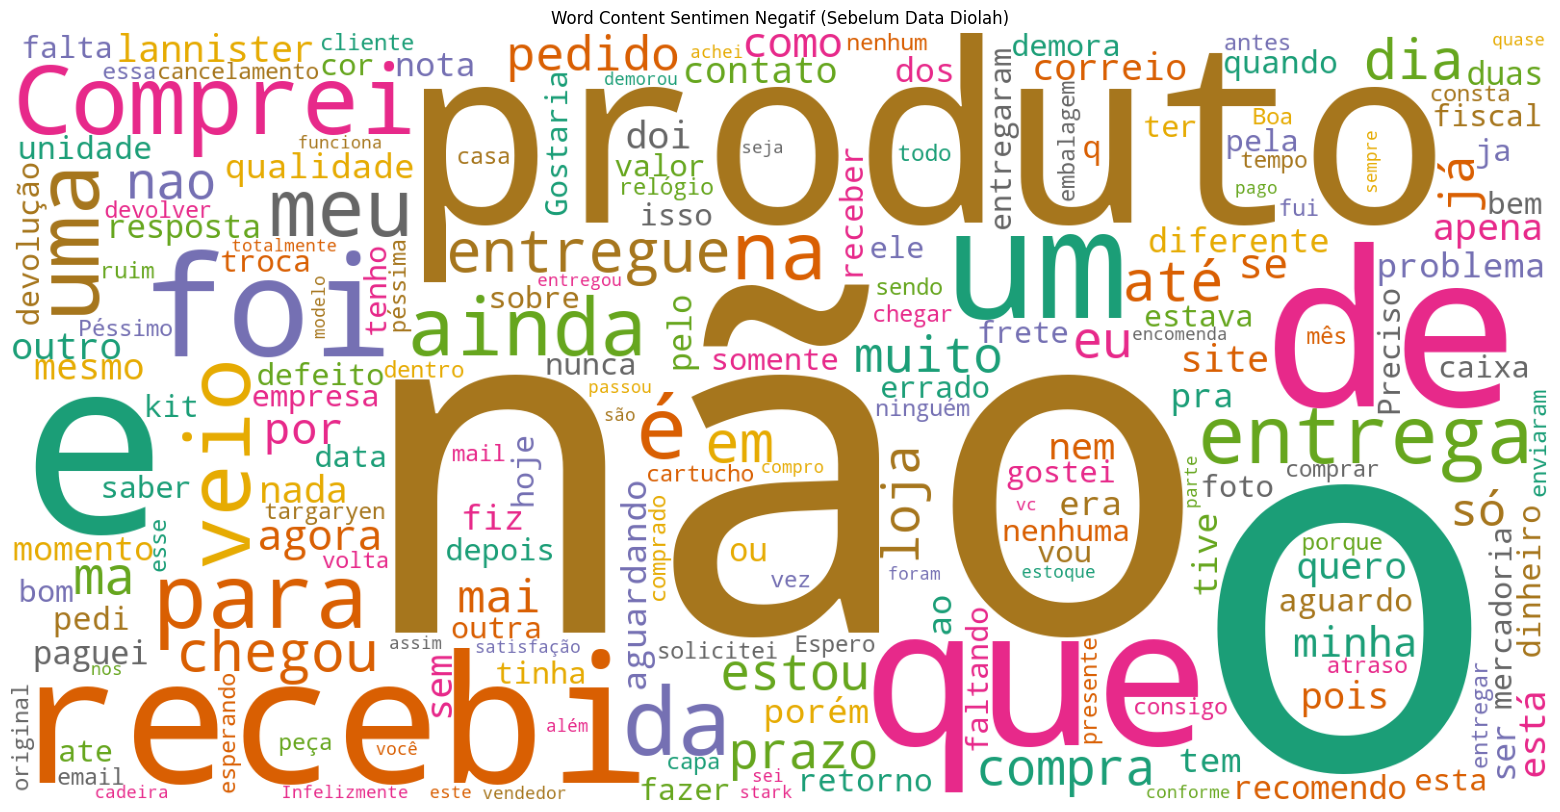

In [15]:
# 1. WORDCLOUD CONTENT SENTIMEN NEGATIF
word_sebelum_diolah_negatif = pd.Series(" ".join(data_sentimen[data_sentimen["sentimen"] == 'negatif']["review_comment_message"]).split())
dat_sebelum_diolah_negatif = " ".join(word_sebelum_diolah_negatif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_sblm_negatif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False).generate(dat_sebelum_diolah_negatif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Negatif (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm_negatif)
plt.axis("off")
plt.show()

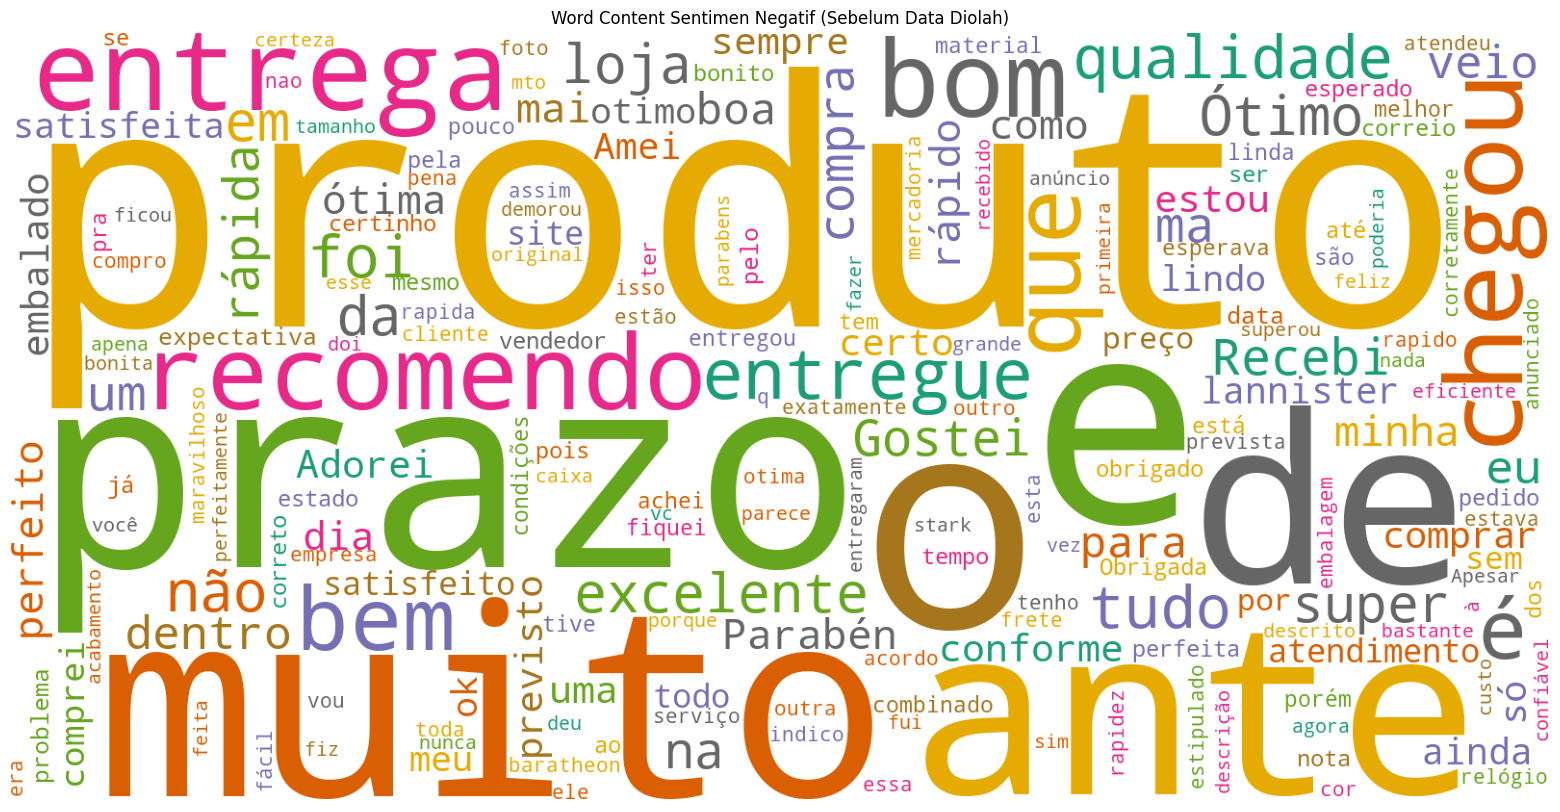

In [16]:
# 1. WORDCLOUD CONTENT SENTIMEN POSITIF

word_sebelum_diolah_negatif = pd.Series(" ".join(data_sentimen[data_sentimen["sentimen"] == 'positif']["review_comment_message"]).split())
dat_sebelum_diolah_negatif = " ".join(word_sebelum_diolah_negatif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_sblm_negatif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False).generate(dat_sebelum_diolah_negatif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Negatif (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm_negatif)
plt.axis("off")
plt.show()

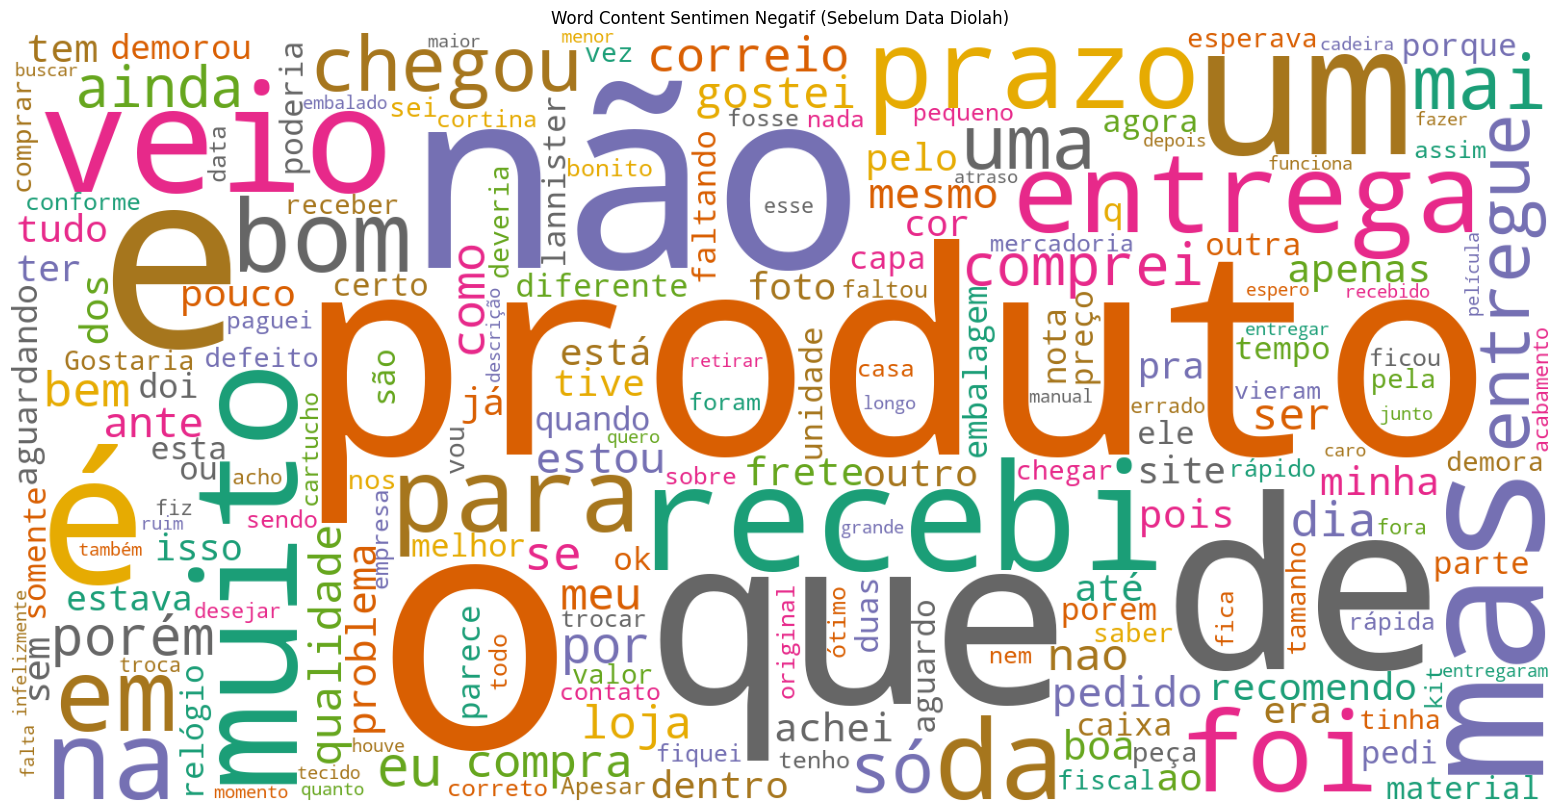

In [17]:
# 1. WORDCLOUD CONTENT SENTIMEN NETRAL
word_sebelum_diolah_negatif = pd.Series(" ".join(data_sentimen[data_sentimen["sentimen"] == 'netral']["review_comment_message"]).split())
dat_sebelum_diolah_negatif = " ".join(word_sebelum_diolah_negatif)

# Unigram (per satu kata) -> "collocations = False"
wordcloud_sblm_negatif = WordCloud(background_color = "white", mode = "RGB", width = 1600, height = 800, colormap = "Dark2", collocations = False).generate(dat_sebelum_diolah_negatif)
plt.figure(figsize = (20, 10))
plt.title("Word Content Sentimen Negatif (Sebelum Data Diolah)")
plt.imshow(wordcloud_sblm_negatif)
plt.axis("off")
plt.show()

# Preprocessing

In [13]:
#cek keseimbangan data
data_sentimen['sentimen'].value_counts()

sentimen
positif    26530
negatif    10890
netral      3557
Name: count, dtype: int64

dikarenakan data tidak seinbalance, maka perlu dilakukan resampling data. Resampling data dilakukan dengan cara mengambil data sebanyak 3500 data tiap label.

In [14]:
#resampling data menjadi 3000 data tiap label
data_sentimen = data_sentimen.groupby('sentimen').apply(lambda x: x.sample(3500)).reset_index(drop=True)

/tmp/ipykernel_4723/3068014541.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sentimen = data_sentimen.groupby('sentimen').apply(lambda x: x.sample(3500)).reset_index(drop=True)


In [15]:
data_sentimen['sentimen'].value_counts()

sentimen
negatif    3500
netral     3500
positif    3500
Name: count, dtype: int64

In [16]:
data_sentimen.head()

,review_comment_message,review_score,sentimen
0,O PRODUTO FOI ENTREGUE POREM FALTANDO PARA AS ...,2,negatif
1,Olá \r\nBoa Noite\r\nAté o momento nao foi ent...,1,negatif
2,A empresa cancelou meu produto mesmo eu espera...,1,negatif
3,Querro estormo,1,negatif
4,Bom,1,negatif


In [17]:
#reset index
data_sentimen = data_sentimen.reset_index(drop=True)
data_sentimen.head()

,review_comment_message,review_score,sentimen
0,O PRODUTO FOI ENTREGUE POREM FALTANDO PARA AS ...,2,negatif
1,Olá \r\nBoa Noite\r\nAté o momento nao foi ent...,1,negatif
2,A empresa cancelou meu produto mesmo eu espera...,1,negatif
3,Querro estormo,1,negatif
4,Bom,1,negatif


In [23]:
sentimen = data_sentimen.copy()

## Penerapan preprocessing
1. Case Folding: Tujuan dari langkah ini adalah untuk memastikan bahwa kata-kata yang sama, tetapi ditulis dengan huruf kapital yang berbeda, tidak dianggap sebagai entitas yang berbeda oleh sistem.
2. Stopword Removal: menghapus kata-kata yang sering muncul dan tidak memberikan informasi yang berguna.
3. Stemming: mengubah kata-kata yang bermakna sama menjadi kata dasarnya.
4. TF-IDF: untuk memberikan bobot atau nilai pada kata-kata dalam suatu dokumen berdasarkan frekuensinya di satu dokumen dan bagaimana distribusinya di banyak dokumen.

In [24]:
# 1. case folding
def clean_review(review):
    import re
    content = review.lower() 
    content = re.sub(r"[^a-z]", " ", content) # hapus semua karakter kecuali a-z
    content = re.sub(r"\t", " ", content) # mengganti tab dengan spasi
    content = re.sub(r"\n", " ", content) # mengganti new line dengan spasi
    content = re.sub(r"\s+", " ", content) # mengganti spasi > 1 dengan 1 spasi
    content = re.sub(r"http\S+|www\S+|https\S+", '', content, flags=re.MULTILINE)
    content = re.sub(r'\d{2}:\d{2}|\d{2}:\d{2}:\d{2}|\d{2}: \d{2}', '', content)
    content = content.strip() # menghapus spasi di awal dan akhir 
    content = re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', content)
    return content


In [25]:
sentimen["review_clean"] = sentimen["review_comment_message"].apply(clean_review)
sentimen.head()

,review_comment_message,review_score,sentimen,review_clean
0,O PRODUTO FOI ENTREGUE POREM FALTANDO PARA AS ...,2,negatif,o produto foi entregue porem faltando para as ...
1,Olá \r\nBoa Noite\r\nAté o momento nao foi ent...,1,negatif,ol boa noite at o momento negação foi entreg...
2,A empresa cancelou meu produto mesmo eu espera...,1,negatif,a empresa cancelou meu produto mesmo eu espera...
3,Querro estormo,1,negatif,querro estormo
4,Bom,1,negatif,bom


In [26]:
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [27]:
# # 2. Stopword Removal
# # NLTK
# import nltk
# from nltk.corpus import stopwords
# 
# stopword_nltk = set(stopwords.words("portuguese"))
# len(stopword_nltk)

In [28]:
# 2. Stopword Removal
def clean_stopword(review,cached_stopwords=stopwords.words('portuguese')):
    review = review.split() # split jadi kata per kata
    review = [w for w in review if w not in cached_stopwords] # hapus stopwords
    review = " ".join(w for w in review) # join semua kata yang bukan stopwords
    
    return review

In [29]:
sentimen["review_comment_message"] = sentimen["review_comment_message"].apply(clean_stopword)
sentimen.head()

,review_comment_message,review_score,sentimen,review_clean
0,O PRODUTO FOI ENTREGUE POREM FALTANDO PARA AS ...,2,negatif,o produto foi entregue porem faltando para as ...
1,Olá Boa Noite Até momento nao entregue pedido ...,1,negatif,ol boa noite at o momento negação foi entreg...
2,"A empresa cancelou produto esperando mês, dera...",1,negatif,a empresa cancelou meu produto mesmo eu espera...
3,Querro estormo,1,negatif,querro estormo
4,Bom,1,negatif,bom


In [30]:
#3. stemming
def stemming(review):
    stemmer = RSLPStemmer()
    review = review.split()
    review = [stemmer.stem(w) for w in review]
    review = " ".join(w for w in review)
    
    return review

In [31]:
sentimen["review_clean"] = sentimen["review_clean"].apply(stemming)
sentimen.head()

,review_comment_message,review_score,sentimen,review_clean
0,O PRODUTO FOI ENTREGUE POREM FALTANDO PARA AS ...,2,negatif,o produt foi entreg por falt par as cade a pe ...
1,Olá Boa Noite Até momento nao entregue pedido ...,1,negatif,ol boa noit at o moment neg foi entreg o meu p...
2,"A empresa cancelou produto esperando mês, dera...",1,negatif,a empr cancel meu produt mesm eu esper um m s ...
3,Querro estormo,1,negatif,querr estorm
4,Bom,1,negatif,bom


In [32]:
X = sentimen["review_clean"]
y = sentimen["sentimen"]

In [33]:
print(X.shape)
print(y.shape)

(10500,)
(10500,)


In [34]:
#4. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

print(X.shape)

(10500, 4343)


# Modelling

In [35]:
# Membuat model menggunakan SVC (SVM Classification)
from sklearn.svm import SVC
svc = SVC(kernel = "linear")

# PAKAI CROSS VAL
from sklearn.model_selection import cross_val_score
accuracies_svc = cross_val_score(estimator = svc, X = X, y = y, cv = 10)
print("Nilai Akurasi SVM 10-Fold: {:.2f}%".format(accuracies_svc.mean() * 100))

Nilai Akurasi SVM 10-Fold: 68.74%


In [36]:
svc.fit(X, y)

SVC(kernel='linear')

In [37]:
list_akurasi = list(accuracies_svc * 100)
list_akurasi

[69.61904761904762,
 67.52380952380952,
 67.14285714285714,
 69.14285714285714,
 68.38095238095238,
 69.61904761904762,
 69.14285714285714,
 70.0,
 68.66666666666667,
 68.19047619047619]

In [38]:
# Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(svc, X, y, cv = 10)
conf_mat = confusion_matrix(y, y_pred)

In [39]:
conf_mat

array([[2596,  793,  111],
       [1025, 1864,  611],
       [ 160,  582, 2758]])

In [40]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

     negatif       0.69      0.74      0.71      3500
      netral       0.58      0.53      0.55      3500
     positif       0.79      0.79      0.79      3500

    accuracy                           0.69     10500
   macro avg       0.68      0.69      0.69     10500
weighted avg       0.68      0.69      0.69     10500



In [43]:
#lakkan hyperparameter tuning dengan random search
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"]
}

grid = RandomizedSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [44]:
grid.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.683 total time=  15.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.671 total time=  13.8s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.673 total time=  13.6s
[CV 4/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.677 total time=  13.9s
[CV 5/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.669 total time=  14.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.405 total time=  17.4s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.391 total time=  17.2s
[CV 3/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.400 total time=  17.4s
[CV 4/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.406 total time=  17.2s
[CV 5/5] END ....C=0.1, gamma=0.01, kernel=poly;, score=0.381 total time=  17.6s
[CV 1/5] END .....C=100, gamma=0.1, kernel=poly;, score=0.479 total time=  17.5s
[CV 2/5] END .....C=100, gamma=0.1, kernel=poly;

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf', 'linear', 'poly',
                                                   'sigmoid']},
                   verbose=3)

In [45]:
grid.best_params_

{'kernel': 'linear', 'gamma': 0.01, 'C': 1}

In [46]:
grid.best_estimator_

SVC(C=1, gamma=0.01, kernel='linear')

In [47]:
grid_predictions = grid.predict(X)

In [48]:
print(classification_report(y, grid_predictions))

              precision    recall  f1-score   support

     negatif       0.78      0.85      0.81      3500
      netral       0.72      0.66      0.69      3500
     positif       0.83      0.84      0.83      3500

    accuracy                           0.78     10500
   macro avg       0.78      0.78      0.78     10500
weighted avg       0.78      0.78      0.78     10500



insght: setelah dilakukan hyperparameter tuning dengan random search, model mengalami peningkatan secara akurasi menjadi 78% dari sebelumnya 69% dengan model SVM

In [49]:
# simpan model hasil hyperparameter tuning
joblib.dump(grid, "model_svc_hyperparameter.pkl")

['model_svc_hyperparameter.pkl']

In [50]:
# load model hasil hyperparameter tuning
model = joblib.load("model_svc_hyperparameter.pkl")

In [41]:
# # save model ke pickle
# import pickle
# 
# # Simpan model dalam bentuk pickle
# with open("model_svc.pkl", "wb") as f:
#     pickle.dump(svc, f)

# Testing dengan kalimat baru

In [51]:
#testing model dengan kalimat baru
def clean_review(review):
    import re
    
    content = review.lower() # menjadikan lowercase
    content = re.sub(r"[^a-z]", " ", content) # hapus semua karakter kecuali a-z
    content = re.sub(r"\t", " ", content) # mengganti tab dengan spasi
    content = re.sub(r"\n", " ", content) # mengganti new line dengan spasi
    content = re.sub(r"\s+", " ", content) # mengganti spasi > 1 dengan 1 spasi
    content = re.sub(r"http\S+|www\S+|https\S+", '', content, flags=re.MULTILINE)
    content = re.sub(r'\d{2}:\d{2}|\d{2}:\d{2}:\d{2}|\d{2}: \d{2}', '', content)
    content = content.strip() # menghapus spasi di awal dan akhir 
    content = re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', content)
    
    return content

def clean_stopword(review):
    from nltk.corpus import stopwords

    stopword_nltk = set(stopwords.words("portuguese"))
    stopword_nltk = stopword_nltk

    review = review.split() # split jadi kata per kata
    review = [w for w in review if w not in stopword_nltk] # hapus stopwords
    review = " ".join(w for w in review) # join semua kata yang bukan stopwords
    
    return review

def stemming(review):
    stemmer = RSLPStemmer()
    review = review.split()
    review = [stemmer.stem(w) for w in review]
    review = " ".join(w for w in review)
    
    return review

In [53]:
def prediksi(df_review):
    df_review = clean_review(df_review)
    df_review = clean_stopword(df_review)
    df_review = vectorizer.transform([df_review])
    hasil = joblib.load("model_svc_hyperparameter.pkl")
    pred = hasil.predict(df_review)
    
    return pred

In [58]:
import pandas as pd
list_coba_review = ["produto muito ruim"]

df_coba_review = pd.DataFrame(list_coba_review, columns = ["coba_review"])
df_coba_review

,coba_review
0,produto muito ruim


In [59]:
prediksi(df_coba_review["coba_review"][0])

array(['negatif'], dtype=object)

# Kesimpulan
1. Model yang digunakan adalah Support Vector Machine (SVM) dengan kernel linear yang menghasilkan akurasi sebesar 78% setelah dilakukan hyperparameter tuning dengan random search.
2. Model dapat digunakan untuk memprediksi sentimen dari review pelanggan terhadap produk yang dijual di e-commerce.


# Saran
1. Melakukan hyperparameter tuning dengan metode lain seperti GridSearchCV untuk mendapatkan parameter yang lebih optimal.
2. Melakukan preprocessing lebih lanjut untuk bahasa portugis agar model dapat lebih akurat dalam memprediksi sentimen.